# Evaluating Geneformer NSCLC cell embeddings

This code imports necessary libraries, filters out certain types of warnings, and imports modules and custom logging objects for use in subsequent operations, related to evaluating the Geneformer model.

In [4]:
import pandas as pd

import Geneformer
import torch

import os
import logging
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import data, cell_embeddings, model_output
from sc_foundation_evals.helpers.custom_logging import log
log.setLevel(logging.INFO)

### Setting up variables

??VRAAG: klopt onderstaande info over one donor?

In the following code snippets, paths and parameters are set up for running a preprocessing pipeline using the Geneformer framework on the 2K NSCLC single-cell RNA sequencing data stored in the AnnData object (adata_donor_1). It specifies paths for input data, the pre-trained Geneformer model, and output directories. Additionally, it defines parameters such as the column names for gene names, batch information, labels, and raw counts within the AnnData object. Note that the batch and label column are set to "batch" because the dataset consists of only one batch and one donor. 

In [5]:
# path for saving results
file_path_out_GF = "/home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/4. output/GF_NSCLC_donor_1"

# path to pre-trained Geneformer:
GF_dir = "/home/cog/nlandzaat/rep_learning_sc_foundation/Geneformer"
dict_dir = os.path.join(GF_dir, "geneformer")

# if possible, use multithreading specify num_workers, -1 means use all available
num_workers = -1

In [6]:
# specify the path to AnnData object
in_dataset_path = "/home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/2.NSCLC notebooks/adata_donor_1.h5ad"

# dataset_name is inferred from in_dataset_path
dataset_name = os.path.basename(in_dataset_path).split(".")[0]
# specify the path for the output of the pre-processing
preprocessed_path = f"/home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/4. output/{dataset_name}/"
# create the preprocessed path if it does not exist
os.makedirs(preprocessed_path, exist_ok=True)

# hieronder stond eig adata.obs, het is vgm var, dus heb dat aangepast, want genen in columns
# in which column in adata.var are gene names stored? if they are in index, the index will be copied to a column with this name
gene_col = "gene_symbols" 
# batch column found in adata.obs
batch_col = "batch"
# where are labels stored in adata.obs? 
label_col = "batch" 
# where are the raw counts stored?
layer_key = "counts" #"X" 

### Loading model and data

The code initializes a Geneformer model instance, loads the pretrained model and vocabulary, and prepares input data for further processing and analysis. The input data object, created using the InputData class from the data module, represents the 2k NSCLC dataset in AnnData format, which will undergo processing with Geneformer.

In [7]:
# create Geneformer instance
geneform = gf.Geneformer_instance(save_dir = file_path_out_GF, 
                                  saved_model_path = GF_dir,
                                  explicit_save_dir = True,
                                  num_workers = num_workers)

INFO     | 2024-04-02 08:38:52 | Using device cuda


In [8]:
# load pretrained model
geneform.load_pretrained_model()

INFO     | 2024-04-02 08:39:28 | Model successfully loaded from /home/cog/nlandzaat/rep_learning_sc_foundation/Geneformer


In [9]:
# load vocabulary
geneform.load_vocab(dict_dir)

In [10]:
# create input data object
input_data = data.InputData(adata_dataset_path = in_dataset_path)

INFO     | 2024-04-02 08:39:28 | Loading data from /home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/2.NSCLC notebooks/adata_donor_1.h5ad


The input data undergoes preprocessing to ensure proper formatting for input into Geneformer. This involves aligning gene names with the vocabulary and filtering cells and genes. Subsequently, a new AnnData object is generated and saved to the specified preprocessed_path as a .loom file.

In [11]:
# preprocess data
input_data.preprocess_data(gene_col = gene_col,
                           model_type = "geneformer",
                           save_ext = "loom",
                           gene_name_id_dict = geneform.gene_name_id,
                           preprocessed_path = preprocessed_path)

WARNING  | 2024-04-02 08:39:30 | Gene names not found in var columns. Using index instead.


INFO     | 2024-04-02 08:39:31 | Matched 79.76% genes (17146/21498) genes in vocabulary of size 40248.


In [12]:
# tokenize data
geneform.tokenize_data(adata_path = os.path.join(preprocessed_path, 
                                                 f"{dataset_name}.loom"),
                       dataset_path = preprocessed_path,
                       cell_type_col = label_col)

Tokenizing /home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/4. output/adata_donor_1/adata_donor_1.loom
/home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/4. output/adata_donor_1/adata_donor_1.loom has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


Map (num_proc=4):   0%|          | 0/1901 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/1901 [00:00<?, ? examples/s]

## Evaluating embeddings

We conduct a forward pass on the model to extract embeddings, employing a batch size of 24 for efficient processing. The embeddings originate from the second-to-last layer, following guidelines from the Geneformer codebase. With the 'layer' argument, layers are referenced per Python conventions: 0 for the embedding layer, 1 for the first layer, and so on, concluding with -1 for the last layer.

Afterward, we set up an evaluation object to assess gene expression predictions using the extracted embeddings. This evaluation includes predictions for a specified cell count, in this case, 500. Rankings are saved as part of the evaluation process.

In [13]:
# extract embeddings
geneform.extract_embeddings(data = input_data,
                            batch_size = 24, # batch_size depends on available GPU memory; should be a multiple of 8
                            layer = -2)

Geneformer (extracting embeddings):   0%|          | 0/80 [00:00<?, ?it/s]

In [14]:
# save embeddings to a DataFrame
GF_embeddings_df = pd.DataFrame(geneform.cell_embeddings)

# save the DataFrame with embeddings to a CSV file
GF_embedding_file_path = "/home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/4. output/GF_embeddings_NSCLC.csv"
GF_embeddings_df.to_csv(GF_embedding_file_path, index=False)

In [15]:
eval_pred = model_output.GeneExprPredEval(geneform, 
                                          output_dir = file_path_out_GF)

In [16]:
eval_pred.evaluate(n_cells = 500,
                   save_rankings = True)

,correlation,mean_correlation
count,500.000000,500.000000
mean,0.822880,0.372659
std,0.046915,0.081216
min,0.674211,0.106399
25%,0.792883,0.319217
50%,0.824587,0.380122
75%,0.852659,0.435325
max,0.977177,0.538028


## Evaluate cell embeddings

The code initializes an evaluation object for cell embeddings using the Geneformer model. Subsequently, it visualizes the embeddings in a UMAP, utilizing a subset of 1000 cells to expedite the process.

In [17]:
# create cell embedding evaluation object
eval_ce = cell_embeddings.CellEmbeddingsEval(geneform,
                                             data = input_data,
                                             output_dir = file_path_out_GF,
                                             label_key = label_col,
                                             batch_key = batch_col)

WARNING  | 2024-04-02 08:52:27 | Copying existing UMAP embedding to X_umap_old and overwriting X_umap.


WARNING  | 2024-04-02 08:52:33 | adata_ has 1901 cells. Taking a subset of 1000 cells.


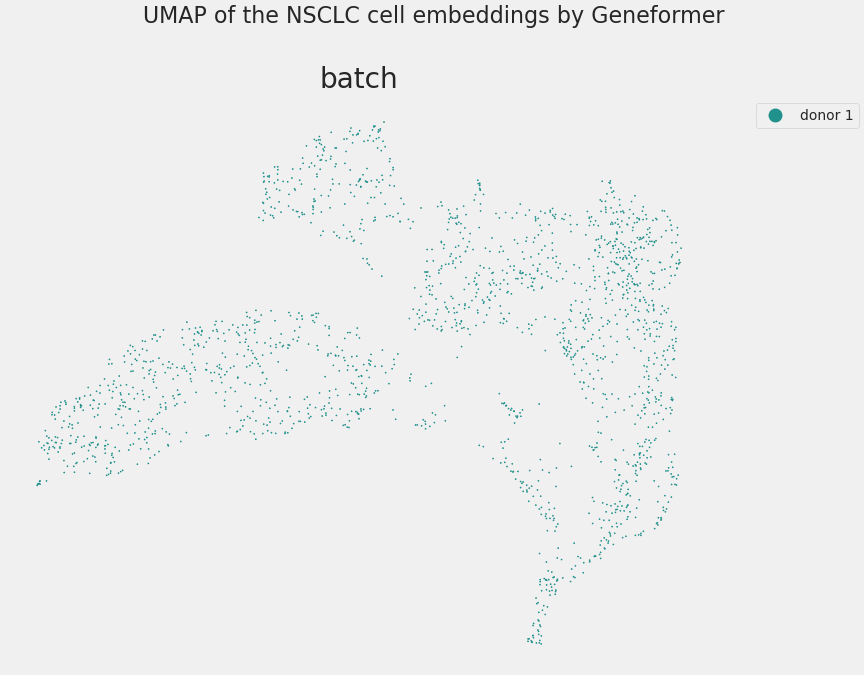

In [23]:
# visualize embeddings
eval_ce.visualize(n_cells = 1000, embedding_key = "geneformer", plot_title = "UMAP of the NSCLC cell embeddings by Geneformer")